# Carbon Modelling Practical

In [1]:
# Initial set-up
import json
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
plt.style.use('seaborn-darkgrid')
%matplotlib inline
from IPython.display import HTML
def css_styling():
    styles = "https://github.com/CamDavidsonPilon/"+\
    "Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/raw/master/styles/custom.css"
    return HTML(styles)

css_styling()
plt.rcParams['figure.figsize']=[14,11]


## Introduction

The main purpose of this practical is to allow students to explore a model of the terrestrial carbon. The model implemented is based on that in JULES ([Best et al., 2011](http://www.geosci-model-dev-discuss.net/4/595/2011/gmdd-4-595-2011.html); [Clark et al., 2011](http://www.geosci-model-dev.net/4/701/2011/gmd-4-701-2011.html)) with some minor modifications. That model is in any case very similar to that of [Sellers et al. (1992)](http://amazonpire.org/PDF/fc2009/readings/Sellers_1992_RSE.pdf). You should probably refresh your memory of the Sellers paper.

The style of the practical will be to give you access to a piece of (modelling) code that you can explore. There are set ‘experiments’ around the codes, e.g. to explore the limiting factors on carbon assimilation at the leaf level under different conditions.

In the last half hour of the session, the course tutor will tell you to stop experimenting and will expect some discussion around the insights gained. You should be prepared to show some figures and possibly tables to support this discussion.

## The code

The main computer code is implemented in Python and available [ here](https://gist.githubusercontent.com/jgomezdans/9231993/raw/photJules.py) (github.com). An easy way to get hold of this is to use the UNIX shell command [`wget`](https://www.gnu.org/s/wget/‎) to download this file into the same directory you are running this notebook from. The next code snippet (execute it by putting the cursor inside anywehre in the grey box and pressing together Ctrl + Enter) will check that the main model is available, and if not, it will download it for you automatically



In [2]:
from photJules import photosynthesis
plt.rcParams['figure.figsize']=[14,11]


A starting point is to produce a function that uses the model in an easy way. The function `do_photosynthesis` does just that. It takes a large number of options, and allows us to do different plots, etc. The parameters are:

* `n`: Length of array (default value: 100 bins)
* `name`: Plot name (plots will be saved as PDF file. Use e.g. `evince` to visualise them)
* `ipar`: Incoming radiation in units of $\mu mol\, m^{−2}s^{−1}$ (default: 200)
* `Tc`: Temperature in degrees Celsius
* `x`: $x$-axis for plots
* `xlabel`: Label of the $x$-axis (for plots)
* `co2_ppmv`: $CO_2$ concentration in units of ppmv
* `C3`: Logical flag for C3 or C4 vegetation
* `pft_type`: type of PFT (see JULES paper for details)
* `plot`: Logical flag indicating whether to do plots or not.



>>> Saved result in test1_a.pdf


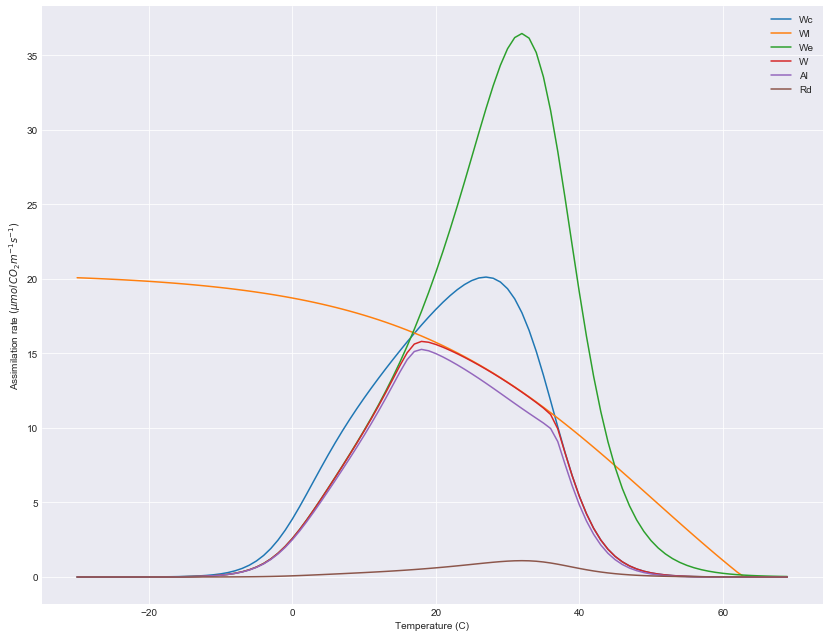

In [3]:

def do_photosynthesis(n=100,name='a',ipar=200.,Tc=None,x=None,xlabel=None,
          co2_ppmv=390,C3=True, pft_type='C3 grass',plot=True):
    '''
    A function do run the photosynthesis model. Function allows the user to change
    a number of important photosynthesis parameters: incoming PAR radiation, canopy
    temperature, CO2 concentration, C3/C4 pathway and the PFT type. The first three
    parameters can be provided as arrays, and the function will show the variation
    of photosynthesis as it sweeps over that parameter range.
    '''
    from photJules import photosynthesis
    photo = photosynthesis()
    photo.data = np.zeros(n)

    # set plant type to C3
    photo.C3 = np.zeros([n]).astype(bool) + C3
    
    photo.Lcarbon = np.ones([n]) * 1
    photo.Rcarbon = np.ones([n]) * 1
    photo.Scarbon = np.ones([n]) * 1

    # set pft type
    # options are:
    # 'C3 grass', 'C4 grass', 'Needleleaf tree', 'Shrub'
    # 'Broadleaf tree'
    # Note that if C4 used, you must set the array
    # self.C3 to False

    photo.pft = np.array([pft_type]*n)

    # set up Ipar, incident PAR in (mol m-2 s-1)
    photo.Ipar = np.ones_like(photo.data) * ipar * 1e-6

    # set co2 (ppmv)
    photo.co2_ppmv = co2_ppmv*np.ones_like(photo.data)

    # set up a temperature range (C)
    try:
        if Tc is None:
            photo.Tc = Tc or np.arange(n)/(1.*n) * 100. - 30.
        else:
            photo.Tc = Tc
    except:
        photo.Tc = Tc
    # initialise
    photo.initialise()
    # reset defaults
    photo.defaults()

    # calculate leaf and canopy photosynthesis
    photo.photosynthesis()

    if plot:
        # plot
        
        if x is None:
            x = photo.Tc
        plt.plot( x, photo.Wc * 1e6,label='Wc')
        plt.plot( x, photo.Wl * 1e6,label='Wl')
        plt.plot( x, photo.We * 1e6,label='We')
        plt.plot( x, photo.W * 1e6,label='W')
        plt.plot( x, photo.Al* 1e6,label='Al')
        plt.plot( x, photo.Rd* 1e6,label='Rd')

        plt.ylabel('Assimilation rate $(\mu mol\, CO_2 m^{-1} s^{-1})$')
        if xlabel is None:
            plt.xlabel('Temperature (C)')
        else:
            plt.xlabel(xlabel)
        plt.legend(loc='best', fontsize=10)
        plt.savefig('test1_{:s}.pdf'.format(name))
        print(">>> Saved result in test1_{:s}.pdf".format(name))
    return photo

do_photosynthesis(name='a')

In this example, we plot leaf assimilation ($W$) as a function of temperature for a $CO_2$ concentration of 390 ppmv, for a C3 grass for incident PAR of 200 $\mu mol\, m^{−2}s^{−1}$.

Also shown on the figure are the Rubisco limiting rate ($Wc$), the light limited rate ($Wl$) and the rate of transport of photosynthetic products (for C3, this would be PEPCarboxylase limitation for C4 plants) ($We$). As in other models, the rate taken for photosynthesis here is the minimum of these limiting rates (actually in JULES, a blending of the rates, but made close to the minimum here).

Finally, the graph also shows the net leaf assimilation rate $Al$, which involves water limitation and the subtraction of leaf dark respiration $Rd$.

We can see that at various temperatures, the different limiting rates take over: up until around 19 C it is limited by the rate of transport of photosynthetic products, then by light, for higher temperatures, by Rubisco. In this model, both $Wc$ and $We$ are scaled by the term $Vcmax$, the maximal rate of carboxylation, which has a temperature limitation (essentially a maximum and minimum temperature for operation) being 36 C and 0 C for C3 grasses here.

$Vcmax$ is also dependent on the leaf nitrogen concentration.

The light limiting rate is dependent on the internal leaf CO2 pressure, $ci$ and the photorespiration compensation point $\Gamma$ that has a temperature dependence. Here, we assume that $ci$ is proportionate to $ca$, which is related to the external CO2 concentration and the atmospheric pressure.

If we increase the light level (the default before was 200, we ramp it up to 500 $\mu mol\,m^{-2}s^{-1}$, we can remove the light limitation:

>>> Saved result in test1_b.pdf


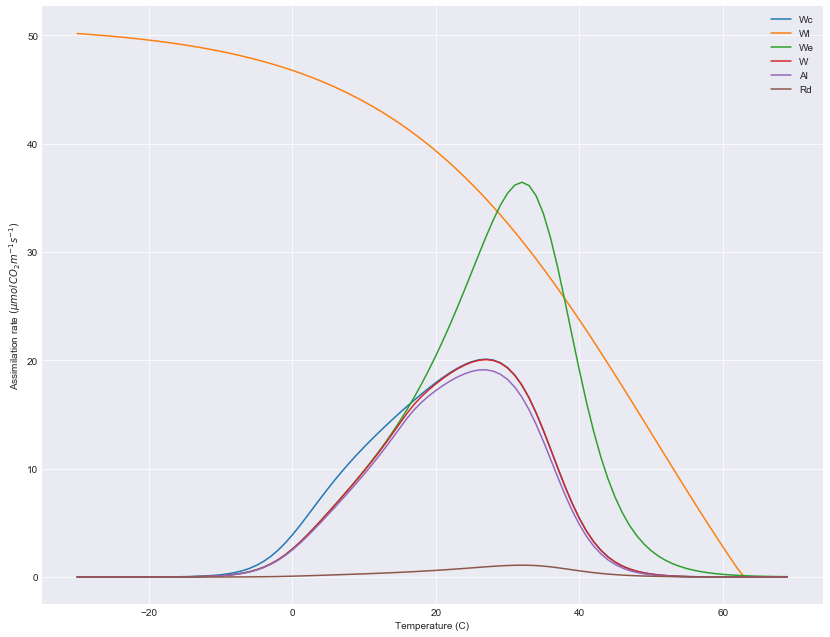

In [4]:
do_photosynthesis ( name='b',ipar=500., co2_ppmv=390 )

### Experiment 1

<div class="alert alert-block alert-info">
Use the code `do_photosynthesis` to explore the limiting factors for the range of vegetation types (PFTs) available here. These are accessed by the optional argument `pft_type`. The list of PFT names understood by this code is

* `C3 grass`
* `C4 grass`
* `Broadleaf tree`
* `Needleleaf tree`
* `Shrub`

You should be interested in the temperature ranges for each PFT (see also tables of parameters in [Clark et al. 2011](http://www.geosci-model-dev.net/4/701/2011/gmd-4-701-2011.html), namely Table 2) and when the different limiting factors kick in for a reasonable range of light conditions and CO2 concentrations. 

You should generate some appropriate graphs and tables and be prepared to discuss these at the end of the session.
</div>

>>> Saved result in test1_shrub.pdf


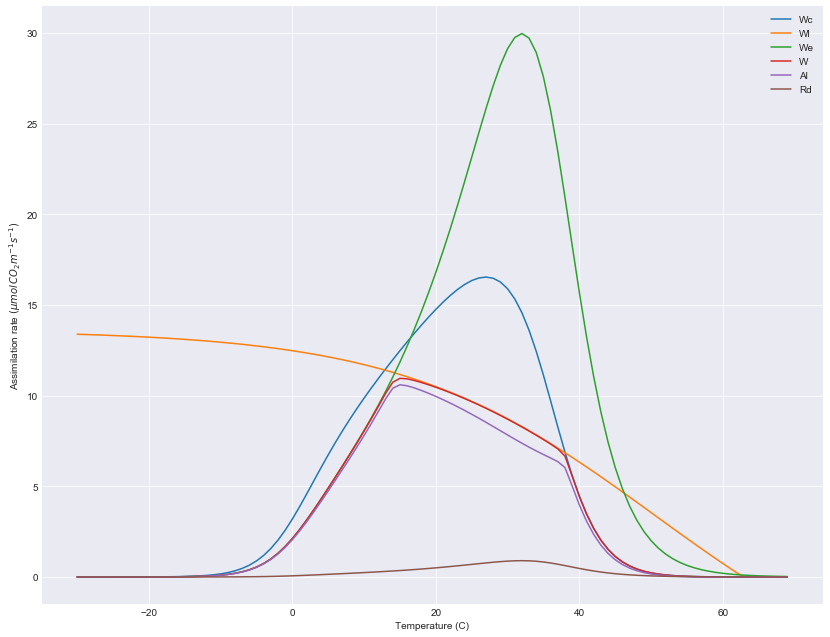

In [5]:
do_photosynthesis( pft_type="Shrub", name="shrub")

## Diurnal variations

We now include a model of solar radiation to examine diurnal variations. We use the [PyEphem](http://rhodesmill.org/pyephem/) Python package, which allows us to calculate the position of the sun with respect to an observer on Earth. Thus we need time as well as longitude and latitude.

<div class="alert alert-block alert-warning">
**DON'T PANIC!!** The next code snippet is given. If you're familiar with Python, you might want to have a look, otherwise, you're just supposed to use it!
</div>

In [6]:
import ephem
import itertools

import scipy.constants


def solar_model(secs, mins, hours, days, months, years, lats, longs, 
                julian_offset='2012/1/1'):
    """A function that calculates the solar zenith angle (sza, in
    degrees), the Earth-Sun distance (in AU?), and the instantaneous 
    downwelling solar radiation in mol(photons) per square meter per
    second for a set of time(s) and geographical locations. """
    solar_constant = 1361. #W/m2
    # energy content of PAR quanta
    energy_par = 220.e-3 # MJmol-1
    # Define the observer
    observer = ephem.Observer()
    # Additionally, add a julian date offset
    if julian_offset != 0:
        julian_offset = ephem.julian_date(julian_offset)
    # Ensure we can easily iterate over all inputs
    # Even if they're scalars
    secs = np.atleast_1d(secs)
    mins = np.atleast_1d(mins)
    hours = np.atleast_1d(hours)
    months = np.atleast_1d(months)
    days = np.atleast_1d(days)
    years = np.atleast_1d(years)
    lats = np.atleast_1d(lats)
    longs = np.atleast_1d(longs)

    # What we return
    julian_day = []
    sza = []
    earth_sun_distance = []
    
    for second, minute, hour, day, month, year, lati, longi in \
        itertools.product(
            secs,mins,hours,days,months,years,lats,longs):
        hour = int(hour)
        minute = int(minute)
        second = int(second)
        observer.date = \
            f'{year:04d}/{month:d}/{day:d} {hour:d}:{minute:d}:{second:d}'
        
        observer.lon = f'{longi:f}'
        observer.lat = f'{lati:f}'
        solar_position = ephem.Sun(observer)
        solar_altitude = max([0, solar_position.alt * 180./np.pi])
        this_sza = 90. - solar_altitude
        this_distance_earth_sun = solar_position.earth_distance
        jd = ephem.julian_date(f'{year:04d}/{month:d}/{day:d}') - julian_offset
        jd += hour/24. + minute/60./24. + second/(3600*24)
        julian_day.append(jd)
        sza.append(this_sza)
        earth_sun_distance.append(this_distance_earth_sun)
        
    
    julian_day = np.array(julian_day)
    sza = np.array(sza)
    earth_sun_distance = np.array(earth_sun_distance)
    iloc = np.argsort(julian_day)
    julian_day = julian_day[iloc]
    sza = sza[iloc]
    earth_sun_distance = earth_sun_distance[iloc]
    solar_radiation = solar_constant/(earth_sun_distance**2)
    # Express radiation in mol(photons) / (m^2 s)
    solar_radiation = solar_radiation/energy_par
    return julian_day, sza, earth_sun_distance, solar_radiation


Once we have this functionality, let's see plot how inputs and outputs to the carbon assimilation model change over a day. For example, the first of January 2012, and over London (latitude of 51 degrees).

We first call the `solar_model` method with the relevant parameters. This provides us with the time axis in units of Julian days, as well as the solar zenith angle (in degrees), the Earth-Sun distance, as well as the solar radiation in mol(phtons)/m^2s.

We can then calculate the amount of incoming PAR. To do this, we assume:
* that PAR is around 50% of total downwelling radiation,
* that the optical thickness of the atmosphere in the PAR region is 0.2
* and that we multiply by all this by $\cos(sza)$ to project on to a flat surface.

The next snippet generates the following plots:

1. the cosine of the solar zenith angle as a function of time
2. the incoming solar radiation in the PAR region
3. the different components that the photosynthesis model calculates
4. the C assimilation rate over the course of a day

<div class="alert alert-block alert-warning">

The last statement in the code snippet saves the entire figure into a PDF file that you can easily browse in the Jupyter notebook file navigation browser tab. The filename by default will be `assimilation_20120101.pdf`. You can add code similar to this at the end of each code block to save the whole image as a plot for reference later. E.g., just change the filename, leaving the `.pdf` extension in place.

`plt.savefig("my_filename.pdf", dpi=150, bbox_inches="tight")`

</div>


>>> Saved result in test1_c.pdf


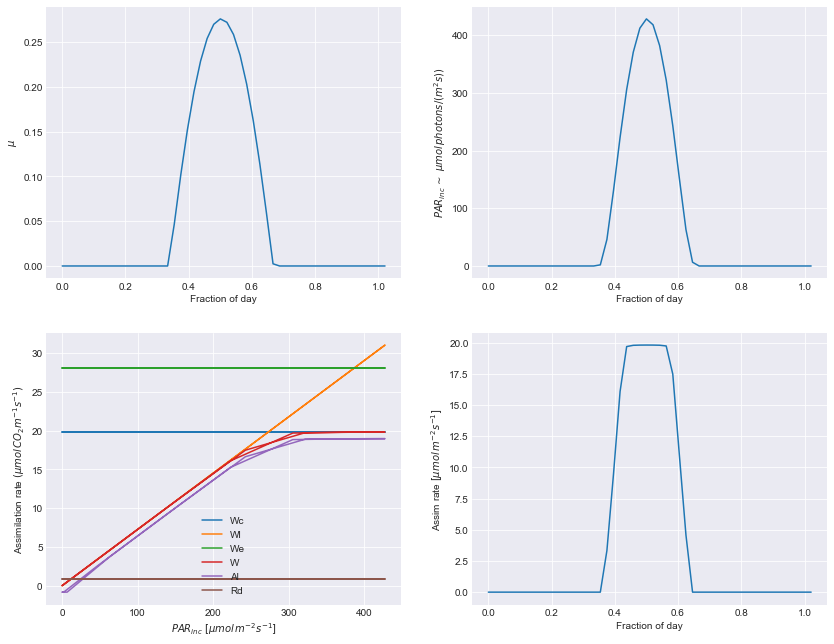

In [7]:
# Calculate solar position over a day, every 30 mins
# for somewhere like London (latitude 51N, Longitude=0)
latitude = 51.
longitude = 0.0
jd, sza, distance, solar_radiation = solar_model(
    0.,np.array([0.,30.]),np.arange(25),1,1,2012,
    latitude, longitude)

sp = plt.subplot( 2, 2, 1 )
sp.plot(jd, np.cos(np.deg2rad(sza)), '-')
sp.set_ylabel("$\mu$")
sp.set_xlabel("Fraction of day")

# assume PAR is 50% of downwelling radiation
# and atmospheric optical thickness of PAR is 0.2
# we multiply by cos(solar zenith) here to project
# onto a flat surface (a 'big leaf')

tau = 0.2
mu = np.cos(np.deg2rad(sza))
ipar = solar_radiation* 0.5 * np.exp(-tau/mu) * mu  # u mol(photons) / (m^2 s)
sp = plt.subplot( 2, 2, 2 )
sp.plot(jd,ipar, '-')
sp.set_ylabel('$PAR_{inc}\,\sim$ $\mu mol\, photons/ (m^2 s))$')
sp.set_xlabel("Fraction of day")

sp = plt.subplot( 2, 2, 3 )
p = do_photosynthesis( n=len(ipar),Tc=25.0,name='c', \
                      ipar=ipar,co2_ppmv=390,x=ipar,\
                      xlabel='$PAR_{inc}$ $[\mu mol\, m^{-2} s^{-1}]$')
sp = plt.subplot( 2, 2, 4 )
# now plot Al + Rd over the day
sp.plot(jd,(p.Al+p.Rd)*1.e6, '-')
sp.set_ylabel('Assim rate $[\mu mol\, m^{-2} s^{-1}]$')
sp.set_xlabel("Fraction of day")


# Can save the figure to a PDF file

plt.savefig("assimilation_20120101.pdf", dpi=150, bbox_inches="tight")


This is quite an interesting figure! If the only thing that varies over the day is the solar radiation intensity, then at this time and latitude, the (leaf) assimilation is ‘pulse’-like over the day: its is limited by light intensity at high solar zenith angles (early morning and late afternoon), then essentially flat.

Normally, the temperature will vary over the day as well, so we could e.g. assume a dependence on solar zenith angle:

Text(0.5, 0, 'Fraction of day')

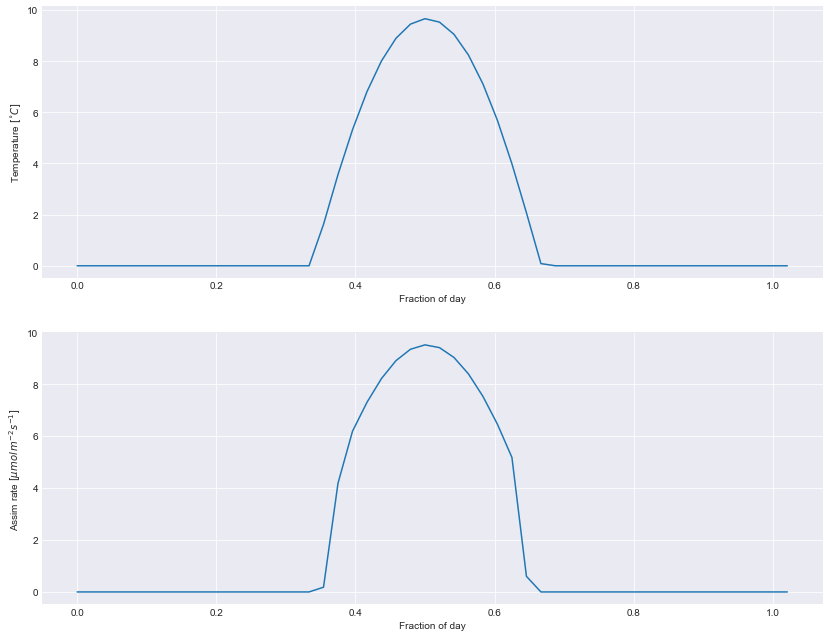

In [8]:
# make temperature a function of cos(solar zenith)
temp = 35. * mu

p = do_photosynthesis(n=len(ipar),Tc=temp, name='c', \
                  ipar=ipar,co2_ppmv=390,x=ipar,xlabel='',plot=None)
sp = plt.subplot( 2, 1, 1 )
sp.plot(jd,temp, '-')
sp.set_xlabel('Fraction of day')
sp.set_ylabel('Temperature $[^{\circ}C]$')


sp = plt.subplot( 2, 1, 2 )
sp.plot(jd,(p.Al+p.Rd)*1e6, '-')
sp.set_ylabel('Assim rate $[\mu mol\, m^{-2} s^{-1}]$')
sp.set_xlabel('Fraction of day')

Now we have dramatically reduced the temperature (remember, the temperature we had before was $25^{\circ}C$ constantly through the day. It now oscillates between 0 and $9^{\circ}C$) so we see a general lowering of the assimilation rate, but we also see a change in the shape.

### Exercise 2

<div class="alert alert-block alert-info">
Using codes similar to those above, explore diurnal variations in leaf assimilation rate at different latitudes and different times of year, for different PFTs (hint: once you have set this up for one example, it should be easy to run for multiple cases).

If possible, you should try to explain what the limiting factors are in each case (hint: plot terms other that `p.Al`, such as `p.Wc`, `p.Wl`, `p.We`).

It would be interesting to summarise such results by calculating the total (leaf) assimilation over the day (N.B. in the above examples, $Al$ is sampled every half hour over the day: you want a result in μmol/m2).

When performing this experiment, think about other complexities that might arise (e.g. how does the idea of phenology fit into this?)
</div>

## Canopy scale assimilation

All of the above experimentation was just at the leaf level. We have essentially looked at responses to temperature and light intensity. Of course, in a ‘real’ canopy, there will be varying amounts of leaf area, so we have to consider how to scale up the leaf-level assimilation to the canopy scale.

Although there are various ways to scale from leaf-level assimilation to the canopy level, we have only implemented what is perhaps the simplest here. This is based on the assumption that there is an acclimatisation of leaf $N$ throughout the canopy (Sellers et al., 1992) giving:
$$
V_m = V_{m0} \overline{f(L)}
$$

where $\overline{f(L)}$ is the average fraction of absorbed PAR (as opposed to instantaneous) at leaf area index (LAI) $L$, $V_{m0}$ is the ‘maximum’ (top leaf) assimilation, and $V_m$ is the canopy-scale assimilation.

Assuming a homogeneous canopy, the canopy scale PAR use efficiency $\Pi$ is:

$$
\Pi = \int_{0}^{L} \overline{f(l)}\,dl. = \left[ \frac{1-e^{-\overline{k}L}}{\overline{k}} \right] = \frac{\overline{fAPAR}}{\overline{k}}
$$


where $\overline{fAPAR}$ is the (average) fraction of absorbed PAR by the canopy and $\overline{k}$ is an effective extinction coefficient:

$$
\overline{k} = \left[ \frac{G(\mu)}{\mu} \right] {(1-\omega_l)}^{\frac{1}{2}}
$$
with $\mu$ the cosine of the (time mean) solar zenith angle (a path length term), $G(\mu)$ the ‘Ross’ or ‘$G$’-function giving the average normalised leaf projection in the direction of the (time mean) incoming radiation, and $\omega_l$ is the leaf single scattering albedo (unity minus leaf absorption) in the PAR region (see Sellers et al., 1992 for more details).

Under these assumptions then, we can calculate canopy scale photosynthesis.

$$
GPP = A_l \frac{\overline{fAPAR}}{\overline{k}}.
$$


Suppose we have an amount of leaf carbon of 0.07 $kg\,C\,m^{−2}$ and a specific leaf density of 0.025 ($kg\,C\,m^{−2}$ per unit of LAI) that is constant throughout the canopy (giving a LAI of 0.07/0.025 = 2.8), and a $G$ gunction of 0.5 (e.g. a spherical leaf angle distribution). We can model this as:

mubar = 0.20
kbar = 2.23
fapar = [0.99808459 0.99808459 0.99808459 ... 0.99808459 0.99808459 0.99808459]


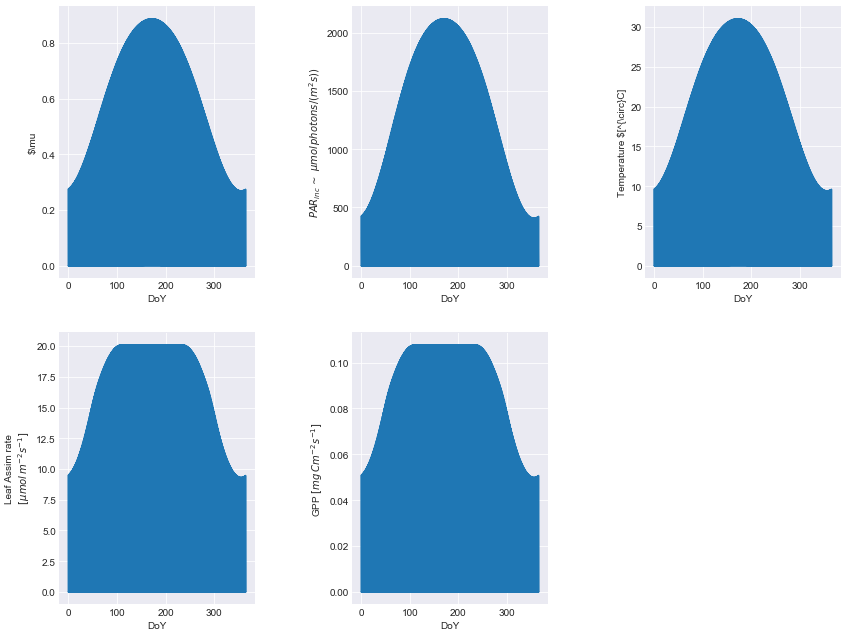

In [9]:
latitude = 51.
longitude = 0.0
jd, sza, distance, solar_radiation = solar_model(
    0.,np.array([0.,30.]),np.arange(25),
    np.arange(1, 366), 1, 2012,
    latitude, longitude)
sp = plt.subplot( 2, 3, 1 )
sp.plot(jd, np.cos(np.deg2rad(sza)), '-')
sp.set_xlabel("DoY")
sp.set_ylabel('$\mu')


# assume PAR is 50% of downwelling radiation
# and atmospheric optical thickness of PAR is 0.2
# we multiply by cos(solar zenith) here to project
# onto a flat surface (a 'big leaf')

tau = 0.2
mu = np.cos(np.deg2rad(sza))
temp = 35.*mu
ipar = solar_radiation* 0.5 * np.exp(-tau/mu) * mu  # u mol(photons) / (m^2 s)
sp = plt.subplot( 2, 3, 2 )
sp.plot(jd,ipar, '-')
sp.set_ylabel('$PAR_{inc}\,\sim$ $\mu mol\, photons/ (m^2 s))$')
sp.set_xlabel("DoY")

sp = plt.subplot( 2, 3, 3 )
sp.plot(jd, temp, '-')
sp.set_xlabel("DoY")
sp.set_ylabel("Temperature $[^{\circ}C]")

# run the leaf level model
p = do_photosynthesis(n=len(ipar),Tc=temp,name='c',ipar=ipar,
                      co2_ppmv=390,plot=None)
sp = plt.subplot( 2, 3, 4 )
# now plot over days the leaf level response
sp.plot(jd, (p.Al + p.Rd)*1.0e6)
sp.set_xlabel("DoY")
sp.set_ylabel("Leaf Assim rate\n $[\mu mol\, m^{-2} s^{-1}]$")


# now we want the canopy level response

p.Lcarbon = 0.07 # kg C m-2
#self.sigmal = 0.025 # kg C m-2 per unit LAI for C3 grass
# for Needleleaf tree: 0.10
# for Broadleaf tree: 0.0375
# for others: 0.05
p.LAI = p.Lcarbon/p.sigmal

# leaf single scattering albedo
p.omega = 0.2

p.G = 0.5
p.mubar = np.mean(mu)
p.kbar = (p.G/p.mubar)*np.sqrt(1-p.omega)
p.fapar = 1 - np.exp(-p.kbar * p.LAI)
print (f'mubar = {p.mubar:.2f}')
print (f'kbar = {p.kbar:.2f}')
print (f'fapar = {p.fapar}')
# kg C m-2 s-1: conversion factor from Clark et al. 2011
p.GPP = 0.012 * (p.Al + p.Rd)* p.fapar / p.kbar

sp = plt.subplot( 2, 3, 5 )
# plot this
sp.plot(jd, p.GPP*1e6, '-')
sp.set_xlabel("DoY")
sp.set_ylabel('GPP $[mg\,C m^{-2}s^{-1}]$')
plt.subplots_adjust(wspace=.5)


The Net Ecosystem Productivity needs the plant respiration terms to be subtracted from the GPP. This is typically split into mainenance and growth respiration: $R_{pm}$ and $R_{pg}$ respectively. In Jules, $R_{pg}$ is assumed to be a fixed fraction of NPP:
$$
R_{p} = R_{pm} + R_{pg}
$$

$$
R_{pg} = r_g\Pi_{G}
$$


where $\Pi_{G}$ is the GPP (the canopy scale assimilation). In Jules, $r_g$ is set to 0.25 for all PFTs (Clark et al., 2011). Leaf maintenance respiration in Jules is the (moisture-modified, through a term $\beta$ that we have not dealt with here) canopy dark respiration (i.e. canopy-scaled). Root and stem respiration are set to depend on the nitrogen concentrations of the root and stem relative to the leaf nitrogen.

Since we have not introduced stem and root biomass yet, we will assume here that leaf, root and (respiring) stem biomass ($L$, $R$ and $S$ respectively) we will assume these terms equal for the moment, since we only require their relative amounts:
$$
R_{pm}=0.012\cdot R_{dc}\left[\beta+\frac{N_r + N_s}{N_l}\right]
$$
where:

$N_x$ is the Nitrogen concentration of biomass component $x$ and the factor 0.012 converts units (see Clark et al., 2011).

$$
N_l = n_m L
$$
$$
N_r = n_m R \mu_{rl}
$$
$$
N_s = n_m S \mu_{sl}
$$

where $\mu_{xl}$ is the relative Nitrogen concentartion of biomass component $x$ to leaf Nitrogen (assumed 1.0 here). $\beta=1$ for unstressed conditions. So:
$$
R_{pm}=0.012\cdot R_{dc}\left[\beta+\frac{R + S}{L}\right]
$$


Text(0, 0.5, 'NPP $[mg\\, C\\, m^{-2} s^{-1}]$')

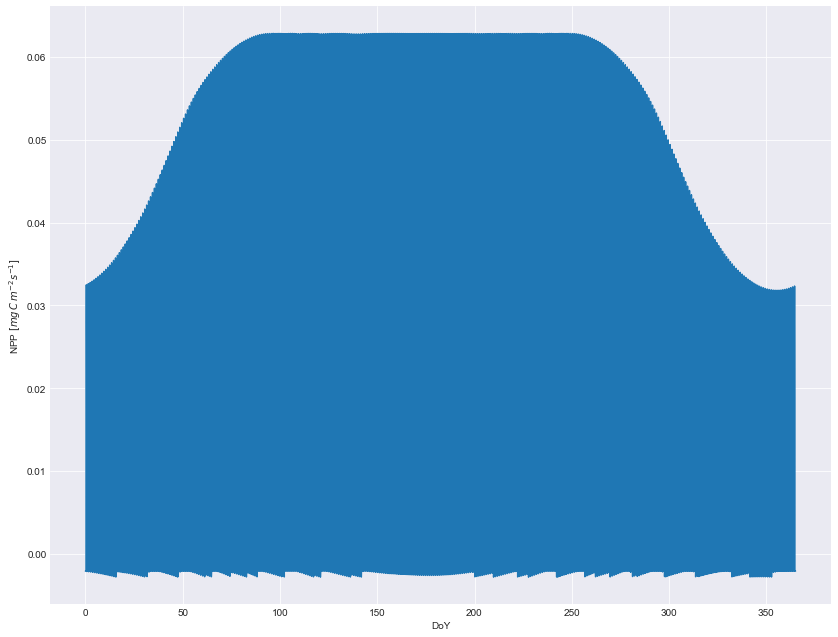

In [10]:
# NPP calculation
p.rg = 0.25
# scale Rd (respiration in the light) up to canopy here
p.Rpm = 0.036 * p.Rd * p.fapar / p.kbar
# Gpp from above, introducing beta
p.PiG = 0.012*( p.Al - p.beta * p.Rd) * p.fapar / p.kbar
# Grow respiration is a fraction of (GPP - maint resp)
p.Rpg = p.rg * (p.PiG - p.Rpm)
# ensure Rpg is non negative
p.Rpg[p.Rpg < 0] = 0.
# total respiration
p.Rp = p.Rpm + p.Rpg
# NPP: calculated as the difference
p.Pi = p.PiG - p.Rp

plt.plot(jd,p.Pi*1e6)
plt.xlabel('DoY')
plt.ylabel('NPP $[mg\, C\, m^{-2} s^{-1}]$')

Since we have calcualted NPP and GPP, we can integrate them over the year:

In [11]:
print('mean NPP = {:.4f} {:s}'.format(np.mean(p.Pi) * 24 * 60 * 60 *1e3,
                                      'g C m-2 day-1'))
print('mean GPP = {:.4f} {:s}'.format(np.mean(p.PiG) * 24 * 60 * 60 * 1e3,
      'g C m-2 day-1'))

# n seconds in year
nsec = 366 * 24 * 60 * 60.
integral = np.mean(p.Pi) * nsec * 1e3 # g C m-2 yr-1
print ("NPP = {:.8g} {:s}".format(integral*1000, 'g C/m2/yr'))


# The total land surface area of the Earth is around 0.292 * 510072000 km^2
# http://chartsbin.com/view/wwu
# so if this were the mean, we would have
global_npp = 0.292 * 510072000 * integral *1e-9
print("Global NPP (rough est.) = {:.6G} {:s}".format(global_npp, 'GT C yr-1'))

mean NPP = 1.5890 g C m-2 day-1
mean GPP = 2.5232 g C m-2 day-1
NPP = 581559.2 g C/m2/yr
Global NPP (rough est.) = 86.618 GT C yr-1


which is certainly an over-estimate by a factor of about 2 because we have assumed high LAI grasslands everywhere on the land surface, but is at least the right order of magnitude.

### Experiment 3

We have shown here how to introduce LAI (or leaf C) into the scaling up to canopy GPP, and also how respiration terms in a model such as Jules can be calculated, which allows us to estimate canopy NPP.

The next parts of a model of this sort include partitioning of the NEP among biomass pools and applying phenological controls.

You could assume a simple, fixed proportion of partitioning of assimilates (e.g. $1/3$ to leaf, root and (respiring) stem biomass pools (i.e. each day, if NPP is positive, you add $1/3$ of the NPP (integrated over 24 hours = 24*60*60 seconds) to the leaf carbon pool (`p.Lcarbon`)). This then increases the LAI.

Since the canopy scaling model here is very simple, it turns out to be just a scalar to $A_l$, so you can first calculate $A_l$ over each day of the year, then, starting at the begining of the time series, start to accumulate carbon (and produce LAI). This gives you a dynamic LAI model (albeit at this moment one that is not controlled by phenology) that you can then use for each daily sample to scale from leaf to canopy GPP and NPP. The only other term that you need to include is a leaf biomass loss (a leaf shedding term, and usually shedding terms for the other pools of carbon). In JULES, this is achieved by defining a leaf turnover rate $\gamma_{lm}$ which is temperature controlled but set to 0.25 (per year) for C3 grasses if the temperature is above a threshold (see p.710 of Clark et al.). We could (very simply) assume then a rate of leaf biomass loss of $0.25L/366$ per day (although in JULES, the rate is based on the maximum seasonal leaf biomass, but we use the actual leaf biomass L here).

<div class="alert alert-block alert-info">
This final exercise then, is to build a dynamic vegetation model, one that ‘grows’ leaf carbon by calculating NPP, allocating a proportion of this to the leaf C pool at the end of each day, then losing a proportion ($0.25L/366$) as litterfall. This should be quite feasible given the codes above, though you might not finish it in this session. If you do complete this, you will find it a very satisfying exercise ... to have created a model of growing plants that links the concepts we have discussed. Although this is a slightly simplified model, it is not greatly less sophisticated than the models currently used in DGVMs, and you can learn a lot by building and trying out a model of this sort.

Once you have built the model, demonstrate its application for some given latitude and (ideally) multiple PFTs.
</div>

### Experiment 4

<div class="alert alert-block alert-info">
Whilst it is an interesting exercise to build and use models of the sort we have created here, there are many flaws with such models. Think carefully about what insights you have gained into both the strengths and weaknesses of such models. You should read the references below carefully to see what criticisms there are in those papers (e.g. complexities about leaf to canopy scaling). You should also think carefully about the role that ‘fixed’ parameters for each PFT have in such models, bearing in mind what has been learned from plant traits databases such as that of Kattge et al., (2011) that was covered in the lecture on Terrestrial Ecosystem Modelling.
</div>
